In [30]:
# Load base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import torch

# load stats tools
from scipy import stats

# load dataset tools
import datasets

# preprocessing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# load models
from sklearn.linear_model import LogisticRegression
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# load eval tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

## Set random  seeds

In [31]:
# set random seeds
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Load Data

In [32]:
anno_df = pd.read_csv("data/AnnotatedData/AnnotatedDUGData.tsv", sep="\t")
load_shape = anno_df.shape

# Prepare data

In [33]:
# we will drop the columns which we are not interested in
anno_df = anno_df[
    [
        "Drug number",
        "Line number",
        "Advice Text",
        "AdviceTag1",
        "AdviceTag2",
        "AdviceTag3",
        "AdviceTag4",
    ]
]

## Extract label_ids

In [34]:
labels = (
    anno_df[["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"]]
    .fillna("")
    .astype(str)
)

label_ids = list(set(labels.values.flatten()))

# remove the empty string
label_ids.remove("")


n_label_ids = len(label_ids)
n_label_ids

8

## Encode advice labels

In [35]:
# Create new columns for each unique tag and initialize them with 0
for lab in label_ids:
    anno_df[lab] = 0

# Update the values to 1 where the tag is present
for lab in label_ids:
    mask = labels.apply(lambda row: lab in row.values, axis=1)
    anno_df.loc[mask, lab] = 1

# Drop the original AdviceTag columns
anno_df.drop(
    columns=["AdviceTag1", "AdviceTag2", "AdviceTag3", "AdviceTag4"],
    inplace=True,
)

# Save the transformed data to a new file
anno_df.head()

,Drug number,Line number,Advice Text,Food or beverage related,Exercise related,Activity or lifestyle related,Temporal,Disease or symptom related,Pregnancy related,Other drugs related,Drug administration related
0,0,34,To reduce the risk of dizziness and lightheade...,0,0,1,0,0,0,0,0
1,0,38,This medication may rarely make your blood sug...,0,0,0,0,1,0,0,0
2,0,43,This medication may rarely cause a condition k...,0,0,0,0,1,0,0,0
3,0,64,This drug may make you dizzy or drowsy or caus...,0,0,1,0,1,0,0,0
4,0,66,Avoid alcoholic beverages.,1,0,0,0,0,0,0,0


### Ensure the encoding was correct

In [36]:
assert anno_df.shape[0] == load_shape[0], "Mismatch in number of rows"

### Label Distribution

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


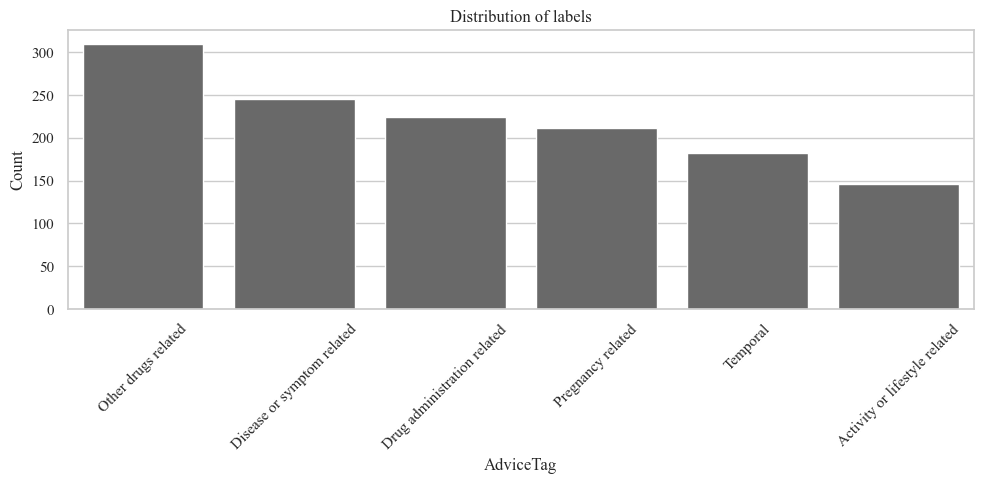

In [89]:
# plot distribution of labels
plot_df = anno_df[anno_df.columns[3:]]
plot_df = plot_df.melt(var_name="AdviceTag", value_name="Count")
plot_df = plot_df.groupby("AdviceTag").sum().reset_index()
plot_df = plot_df.sort_values("Count", ascending=False)
plot_df

# set style
sns.set_style("whitegrid")

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="AdviceTag", y="Count", color="dimgray")
plt.xticks(rotation=45)
plt.title("Distribution of labels")
plt.tight_layout()
plt.savefig("./images/label_distribution.png")
plt.show()

# Baseline Predictions


The  baseline will be a random baseline, where the labels are randomly assigned to the advice text.

The baseline will be evaluated using the F1 score, Precision, and Recall.

In [38]:
def rand_baseline_pred(dataset, n_labels=8):
    return np.random.randint(0, 2, size=(len(dataset), n_labels))

## Load data into dataset

In [39]:
multi_label = datasets.Dataset.from_pandas(anno_df)

## Evaluate the baseline

### Identify ground truth labels

In [40]:
ground_truth = anno_df[label_ids].values

In [41]:
assert ground_truth.shape[0] == load_shape[0], "Mismatch in number of rows"
assert ground_truth.shape[1] == n_label_ids, "Mismatch in number of columns"

### Make predictions and evaluate

#### Random Baseline

In [42]:
# make predictions
rand_preds = rand_baseline_pred(multi_label)
# print(rand_preds.shape)
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth, rand_preds, average="micro"
)
print(f"Random Precision: {precision}, Recall: {recall}, F1: {f1}")

Random Precision: 0.19695076230942266, Recall: 0.489137181874612, F1: 0.2808267997148967


In [43]:
model_results = []

In [44]:
# save baseline
model_results.append(
    {
        "model": "Random Baseline",
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
)

# Train, Test Split

In [45]:
# Drop the unneeded columns
anno_df.drop(["Drug number", "Line number"], axis=1, inplace=True)

# Create train test split
train, test = train_test_split(anno_df, test_size=0.2, random_state=42)

# Binary Relevance

For binary relevance we will encode the text using a TF-IDF vectorizer and then train a logistic regression model for each label.

In [46]:
# look at our data
train.head()

,Advice Text,Food or beverage related,Exercise related,Activity or lifestyle related,Temporal,Disease or symptom related,Pregnancy related,Other drugs related,Drug administration related
78,Some products that may interact with this drug...,0,0,0,0,0,0,1,0
29,"Beta-blocker medications (such as metoprolol, ...",0,0,0,0,1,0,1,0
280,Wash your hands after applying the patch.,0,0,1,0,0,0,0,1
507,Lithium passes into breast milk and may have u...,0,0,0,0,0,1,0,0
652,Limit alcoholic beverages.,1,0,0,0,0,0,0,0


## Data encoding with TF-IDF

In [47]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the train data
X_train = vectorizer.fit_transform(train["Advice Text"])

# Transform the test data
X_test = vectorizer.transform(test["Advice Text"])

label_ids = train.columns[1:]
label_ids

Index(['Food or beverage related', 'Exercise related',
       'Activity or lifestyle related', 'Temporal',
       'Disease or symptom related', 'Pregnancy related',
       'Other drugs related', 'Drug administration related'],
      dtype='object')

### Training

In [48]:
# Initialize the models
lr = LogisticRegression(max_iter=1000)
svc = LinearSVC(max_iter=1000)
kn = KNeighborsClassifier(n_neighbors=3)

models = [
    ("Logistic Regression", lr),
    ("Linear SVC", svc),
    ("K-Nearest Neighbors", kn),
]

In [49]:
for model_name, model in models:
    results = pd.DataFrame()

    for label in label_ids:

        y_train = train[label]

        y_test = test[label]

        # Train the model

        model.fit(X_train, y_train)

        # Predict the test data

        preds = model.predict(X_test)

        results[label] = preds

    # Evaluate the model

    precision, recall, f1, _ = precision_recall_fscore_support(
        test[label_ids], results, average="micro"
    )

    print(f"\n{model_name} Results")
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

    model_results.append(
        {
            "model": f"Binary Relevance - {model_name}",
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
    )


Logistic Regression Results
Precision: 0.8918918918918919, Recall: 0.6346153846153846, F1: 0.7415730337078652

Linear SVC Results
Precision: 0.8862068965517241, Recall: 0.8237179487179487, F1: 0.8538205980066444


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua


K-Nearest Neighbors Results
Precision: 0.8263665594855305, Recall: 0.8237179487179487, F1: 0.8250401284109149


# Transformer Based Model

In [50]:
model_id = "roberta-base"

## Create evaluation split

In [51]:
train, val = train_test_split(train, test_size=0.3, random_state=42)

In [52]:
# Load into datasets
train_dataset = datasets.Dataset.from_pandas(train, preserve_index=False)
val_dataset = datasets.Dataset.from_pandas(val, preserve_index=False)
test_dataset = datasets.Dataset.from_pandas(test, preserve_index=False)

In [53]:
# rename Advice Text to text
train_dataset = train_dataset.rename_column("Advice Text", "text")
val_dataset = val_dataset.rename_column("Advice Text", "text")
test_dataset = test_dataset.rename_column("Advice Text", "text")

## Tokenize text

In [54]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [55]:
def preprocess_text(batch, tokenizer=tokenizer):

    text = batch["text"]
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )

    labels = list(batch.keys())[1:]

    label_array = np.zeros((len(text), len(labels)))

    for i, label in enumerate(labels):
        label_array[:, i] = batch[label]

    inputs["labels"] = label_array

    return inputs

In [56]:
train_encodings = train_dataset.map(preprocess_text, batched=True)
eval_encodings = val_dataset.map(preprocess_text, batched=True)
test_encodings = test_dataset.map(preprocess_text, batched=True)

Map:   0%|          | 0/562 [00:00<?, ? examples/s]

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

In [57]:
# format datasets
train_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
eval_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
test_encodings.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

### Create label mapping

In [58]:
class_names = anno_df.columns[1:].tolist()
n_labels = len(class_names)

id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

## Load pre-trained model

### Training Arguements

In [59]:
training_args = TrainingArguments(
    output_dir=f"./models/advice_labeling/{model_id}",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=25,
    logging_dir=f"./logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="steps",
    save_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="wandb",
)

### Define Metrics Function

In [60]:
# metrics function
def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    preds = (probs > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )

    return {"precision": precision, "recall": recall, "f1": f1}

### Load the model

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=n_labels, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Setup Trainer

In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=eval_encodings,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the model

In [63]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mattcalc. Use `wandb login --relogin` to force relogin


  0%|          | 0/213 [00:00<?, ?it/s]

{'loss': 0.7151, 'grad_norm': 1.4600509405136108, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.14}
{'loss': 0.7018, 'grad_norm': 0.8964548707008362, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.28}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.6997018456459045, 'eval_precision': 0.18801652892561985, 'eval_recall': 0.48148148148148145, 'eval_f1': 0.2704309063893016, 'eval_runtime': 24.732, 'eval_samples_per_second': 9.785, 'eval_steps_per_second': 1.253, 'epoch': 0.35}
{'loss': 0.7043, 'grad_norm': 1.2370301485061646, 'learning_rate': 3e-06, 'epoch': 0.42}
{'loss': 0.6803, 'grad_norm': 1.0666874647140503, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.56}
{'loss': 0.6676, 'grad_norm': 0.9837712049484253, 'learning_rate': 5e-06, 'epoch': 0.7}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.6635945439338684, 'eval_precision': 0.25486381322957197, 'eval_recall': 0.34656084656084657, 'eval_f1': 0.2937219730941704, 'eval_runtime': 23.9329, 'eval_samples_per_second': 10.112, 'eval_steps_per_second': 1.295, 'epoch': 0.7}
{'loss': 0.6306, 'grad_norm': 2.091649055480957, 'learning_rate': 6e-06, 'epoch': 0.85}
{'loss': 0.5651, 'grad_norm': 1.6046805381774902, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.99}


  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4838559627532959, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 23.7864, 'eval_samples_per_second': 10.174, 'eval_steps_per_second': 1.303, 'epoch': 1.06}
{'loss': 0.5138, 'grad_norm': 1.5874605178833008, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.13}
{'loss': 0.4765, 'grad_norm': 1.4560497999191284, 'learning_rate': 9e-06, 'epoch': 1.27}
{'loss': 0.4347, 'grad_norm': 1.7774271965026855, 'learning_rate': 1e-05, 'epoch': 1.41}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.3954368233680725, 'eval_precision': 0.95, 'eval_recall': 0.20105820105820105, 'eval_f1': 0.33187772925764186, 'eval_runtime': 23.5655, 'eval_samples_per_second': 10.269, 'eval_steps_per_second': 1.315, 'epoch': 1.41}
{'loss': 0.4094, 'grad_norm': 1.604883074760437, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.55}
{'loss': 0.3676, 'grad_norm': 1.57388436794281, 'learning_rate': 1.2e-05, 'epoch': 1.69}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.3226909041404724, 'eval_precision': 0.9090909090909091, 'eval_recall': 0.6084656084656085, 'eval_f1': 0.7290015847860539, 'eval_runtime': 23.5037, 'eval_samples_per_second': 10.296, 'eval_steps_per_second': 1.319, 'epoch': 1.76}
{'loss': 0.3496, 'grad_norm': 1.67842698097229, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.83}
{'loss': 0.3381, 'grad_norm': 1.9925715923309326, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.97}
{'loss': 0.2902, 'grad_norm': 1.592902421951294, 'learning_rate': 1.5e-05, 'epoch': 2.11}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.27162879705429077, 'eval_precision': 0.8896103896103896, 'eval_recall': 0.7248677248677249, 'eval_f1': 0.7988338192419825, 'eval_runtime': 23.5697, 'eval_samples_per_second': 10.267, 'eval_steps_per_second': 1.315, 'epoch': 2.11}
{'loss': 0.2623, 'grad_norm': 1.116321086883545, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.25}
{'loss': 0.2517, 'grad_norm': 1.5033735036849976, 'learning_rate': 1.7000000000000003e-05, 'epoch': 2.39}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.22243700921535492, 'eval_precision': 0.9453924914675768, 'eval_recall': 0.7328042328042328, 'eval_f1': 0.8256333830104322, 'eval_runtime': 23.6109, 'eval_samples_per_second': 10.249, 'eval_steps_per_second': 1.313, 'epoch': 2.46}
{'loss': 0.2403, 'grad_norm': 1.878165364265442, 'learning_rate': 1.8e-05, 'epoch': 2.54}
{'loss': 0.2236, 'grad_norm': 2.171985387802124, 'learning_rate': 1.9e-05, 'epoch': 2.68}
{'loss': 0.2193, 'grad_norm': 1.2557334899902344, 'learning_rate': 2e-05, 'epoch': 2.82}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.20272086560726166, 'eval_precision': 0.9050445103857567, 'eval_recall': 0.8068783068783069, 'eval_f1': 0.8531468531468532, 'eval_runtime': 23.4822, 'eval_samples_per_second': 10.306, 'eval_steps_per_second': 1.32, 'epoch': 2.82}
{'loss': 0.2201, 'grad_norm': 1.121904969215393, 'learning_rate': 2.1e-05, 'epoch': 2.96}
{'train_runtime': 642.2575, 'train_samples_per_second': 2.625, 'train_steps_per_second': 0.332, 'train_loss': 0.437830345171718, 'epoch': 3.0}


TrainOutput(global_step=213, training_loss=0.437830345171718, metrics={'train_runtime': 642.2575, 'train_samples_per_second': 2.625, 'train_steps_per_second': 0.332, 'train_loss': 0.437830345171718, 'epoch': 3.0})

### Evaluate Trained Model

In [64]:
trainer.evaluate()

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.20272086560726166,
 'eval_precision': 0.9050445103857567,
 'eval_recall': 0.8068783068783069,
 'eval_f1': 0.8531468531468532,
 'eval_runtime': 23.1354,
 'eval_samples_per_second': 10.46,
 'eval_steps_per_second': 1.34,
 'epoch': 3.0}

## Test data predictions and evaluation

After training the model, predictions are made on the withheld data and evaluated

In [65]:
# evaluate on test set
test_results = trainer.predict(test_encodings)

test_metrics = compute_metrics(test_results)
print(test_metrics)

  0%|          | 0/26 [00:00<?, ?it/s]

{'precision': 0.8732394366197183, 'recall': 0.7948717948717948, 'f1': 0.832214765100671}


In [66]:
# add results
model_results.append(
    {
        "model": model_id,
        "precision": test_metrics["precision"],
        "recall": test_metrics["recall"],
        "f1": test_metrics["f1"],
    }
)

# Model Results

## Plot results

In [67]:
# plot model results
model_results_df = pd.DataFrame(model_results)

# save model results
model_results_df.to_csv("model_results.csv", index=False)

In [68]:
# melt the datafram
model_results_melt = model_results_df.melt(id_vars="model", var_name="metric")

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

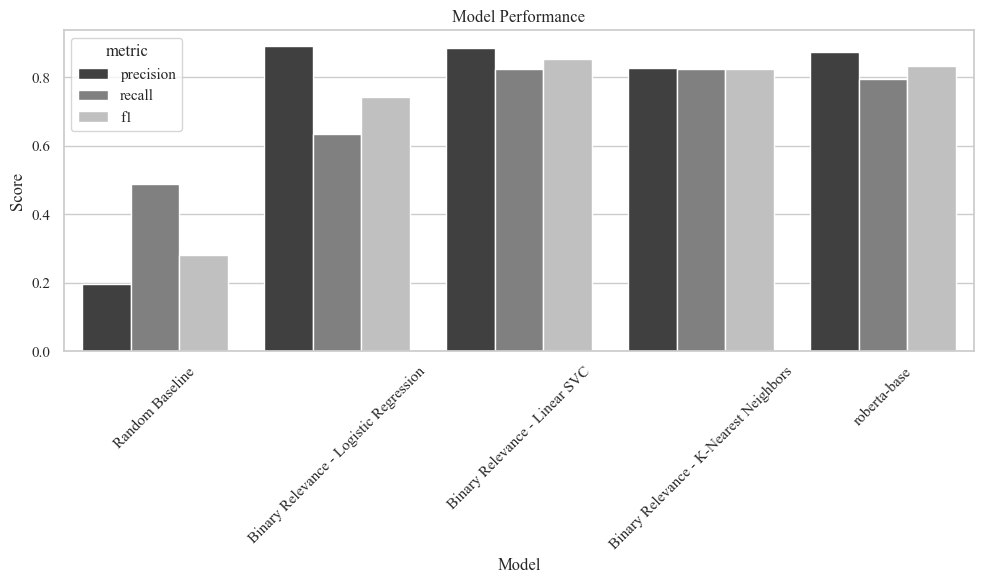

In [85]:
# set style
sns.set_style("whitegrid")

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# plot


plt.figure(figsize=(10, 6))


sns.barplot(
    data=model_results_melt, x="model", y="value", hue="metric", palette="gray"
)

# plt.legend(bbox_to_anchor=(0.8, 1.01), loc="upper center", ncol=3)


plt.title("Model Performance")


plt.ylabel("Score")


plt.xlabel("Model")


plt.xticks(rotation=45)

# tight layout
plt.tight_layout()

# save plot
plt.savefig("./images/al_model_performance.png")


plt.show()

<Figure size 640x480 with 0 Axes>